In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.tsa.stattools import acf
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [5]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

query1 = '''
SELECT
  *
FROM
  weatherinszeged
'''

query2='''
SELECT
    *
FROM
    houseprices
'''

temp_df = pd.read_sql_query(query1, con=engine)

postgres_db = 'houseprices'
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.read_sql_query(query2, con=engine)
engine.dispose()

In [6]:
temp_df.info()
houseprices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   date                 96453 non-null  datetime64[ns, UTC]
 1   summary              96453 non-null  object             
 2   preciptype           96453 non-null  object             
 3   temperature          96453 non-null  float64            
 4   apparenttemperature  96453 non-null  float64            
 5   humidity             96453 non-null  float64            
 6   windspeed            96453 non-null  float64            
 7   windbearing          96453 non-null  float64            
 8   visibility           96453 non-null  float64            
 9   loudcover            96453 non-null  float64            
 10  pressure             96453 non-null  float64            
 11  dailysummary         96453 non-null  object             
dtypes: datetime64[ns, 

First, load the dataset from the weatherinszeged table from Thinkful's database.

Build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.

Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

In [7]:
temp_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [8]:
temp_features = temp_df[['humidity', 'windspeed', 'windbearing', 'pressure', 'temperature']]

In [9]:
temp_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   humidity     96453 non-null  float64
 1   windspeed    96453 non-null  float64
 2   windbearing  96453 non-null  float64
 3   pressure     96453 non-null  float64
 4   temperature  96453 non-null  float64
dtypes: float64(5)
memory usage: 3.7 MB


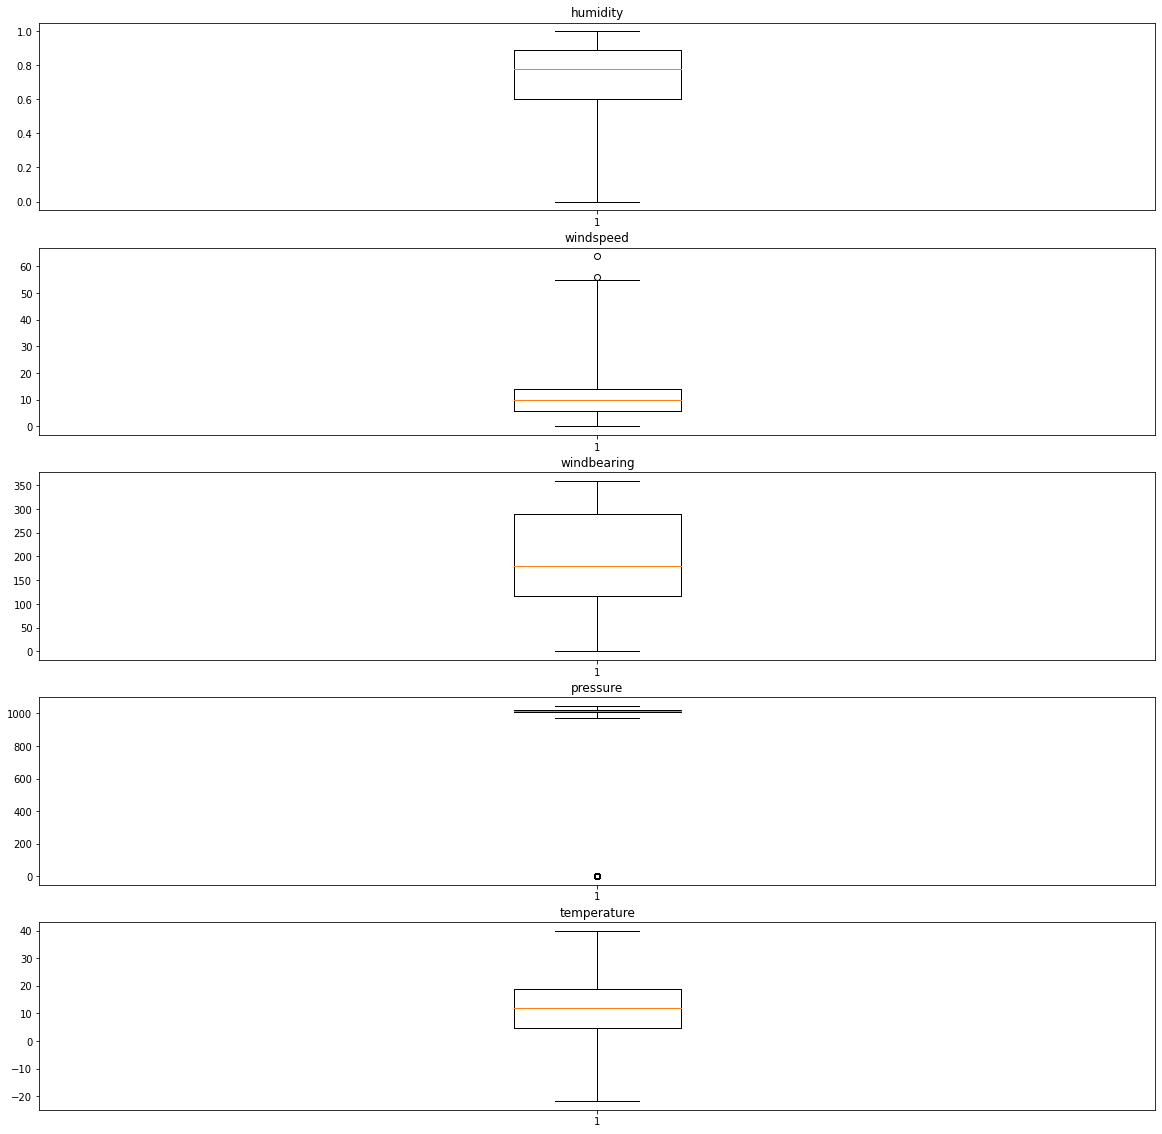

In [10]:
plt.figure(figsize=(20,20))
for i, column in enumerate(temp_features):
    plt.subplot(5, 1, i+1)
    plt.boxplot(temp_features[column], whis=5)
    plt.title(column)
plt.show()

In [11]:
temp_features['pressure'].nunique()

4979

In [42]:
X1 = temp_features.drop(['temperature'], axis=1)
y1 = temp_features['temperature']

In [43]:
X1 = sm.add_constant(X1)

results = sm.OLS(y1, X1).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 1.750e+04
Date:                Wed, 26 Aug 2020   Prob (F-statistic):               0.00
Time:                        20:51:04   Log-Likelihood:            -3.2821e+05
No. Observations:               96453   AIC:                         6.564e+05
Df Residuals:                   96448   BIC:                         6.565e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.9264      0.233    162.709      0.000      37.470      38.383
humidity      -32.4962      0.123   -264.288      0.000     -32.737     -32.255
windspeed      -0.2014      0.003    -57.557      0.000      -0.208      -0.195
windbearing     0.0040      0.000     18.463      0.000       0.004       0.004
pressure       -0.0007      0.000     -3.452      0.001      -0.001      -0.000
==============================================================================
Omnibus:                     3375.432   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3793.297
Skew:                          -0.455   Prob(JB):                         0.00
Kurtosis:                       3.339   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
predictions1 = results.predict(X1)
errors1 = y1 - predictions1

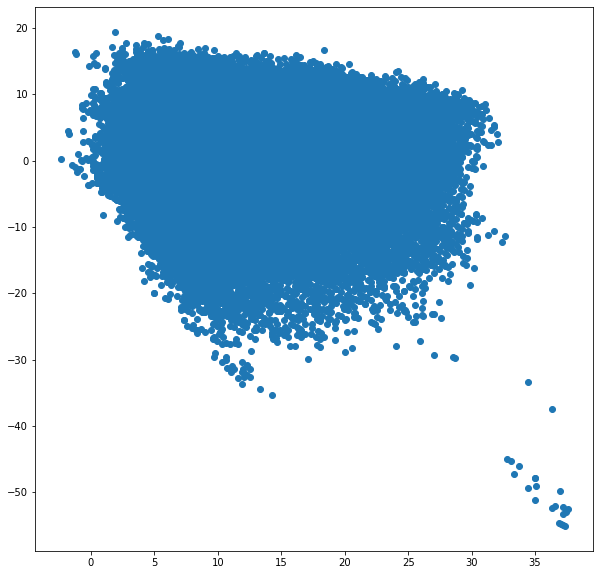

In [45]:
plt.figure(figsize=(10,10))
plt.scatter(predictions1, errors1)

In [46]:
bart_stats = bartlett(predictions1, errors1)
lev_stats = levene(predictions1, errors1)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


We do not meet the assumption of homoscedasticity.

In [47]:
X1.corr()

,const,humidity,windspeed,windbearing,pressure
const,NaN,NaN,NaN,NaN,NaN
humidity,NaN,1.000000,-0.224951,0.000735,0.005454
windspeed,NaN,-0.224951,1.000000,0.103822,-0.049263
windbearing,NaN,0.000735,0.103822,1.000000,-0.011651
pressure,NaN,0.005454,-0.049263,-0.011651,1.000000


We do meet the assumption of low multicollinearity

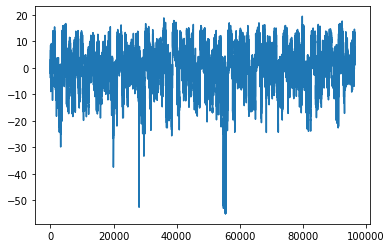

In [48]:
plt.plot(errors1)

/home/owenhw/conda/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


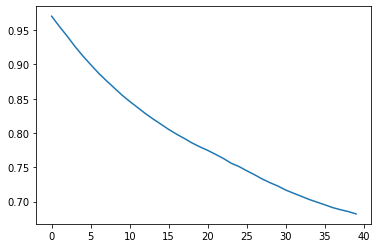

In [49]:
acf_data = acf(errors1)

plt.plot(acf_data[1:])
plt.show()

Here we see that errors are hightly correlated with one another. Between 1 and .7

<AxesSubplot:>

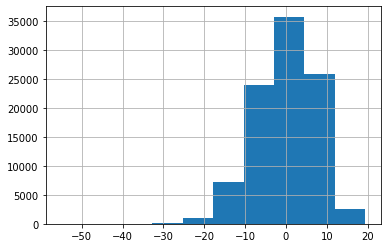

In [50]:
errors1.hist()

In [51]:
jb_stats = jarque_bera(errors1)
norm_stats = normaltest(errors1)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3793.296735252289 and p value is 0.0
Normality test statistics is 3375.432307699525 and p value is 0.0


These errors are not normally distributed.

Our model fails to meet many of the assumptions of linear regression and therefore can't be evaluated as reliable. Many of the symptoms indicate that we may be missing key features. Furthermore the pressure feature contains outliers and our target variable was not normalized. For a second pass we should include more featuers and propperly clean and treat the data to ensure a better fit.

In [22]:
houseprices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [23]:
features = ['overallcond', 'totrmsabvgrd', 'neighborhood', 'yearremodadd', 'mszoning', 'saleprice']

In [24]:
houseprices_data = houseprices_df[features]

In [25]:
houseprices_data.loc[:, 'overallcond'] += 100

/home/owenhw/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [26]:
houseprices_data.head()

,overallcond,totrmsabvgrd,neighborhood,yearremodadd,mszoning,saleprice
0,105,8,CollgCr,2003,RL,208500
1,108,6,Veenker,1976,RL,181500
2,105,6,CollgCr,2002,RL,223500
3,105,7,Crawfor,1970,RL,140000
4,105,9,NoRidge,2000,RL,250000


In [29]:
data_df = houseprices_data['saleprice']

for column in ['overallcond', 'totrmsabvgrd', 'neighborhood', 'mszoning']:
    data_df = pd.concat([data_df, pd.get_dummies(houseprices_data[column], drop_first=True)]
                                , axis=1)

In [30]:
data_df.head()

,saleprice,102,103,104,105,106,107,108,109,3,...,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,FV,RH,RL,RM
0,208500,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,181500,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
2,223500,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,140000,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,250000,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [57]:
y2 = data_df['saleprice']
X2 = data_df.drop(['saleprice'], axis=1)

In [58]:
lrm2 = linear_model.LinearRegression()
lrm.fit(X2, y2)

LinearRegression()

In [59]:
X2 = sm.add_constant(X2)

results2 = sm.OLS(y2, X2).fit()

results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     64.00
Date:                Wed, 26 Aug 2020   Prob (F-statistic):          7.98e-312
Time:                        21:27:23   Log-Likelihood:                -17711.
No. Observations:                1460   AIC:                         3.552e+04
Df Residuals:                    1412   BIC:                         3.577e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.035e+04   6.95e+04      0.868      0.385    -7.6e+04    1.97e+05
102         2.578e+04   5.07e+04      0.508      0.611   -7.37e+04    1.25e+05
103         1.128e+04   4.69e+04      0.240      0.810   -8.07e+04    1.03e+05
104         1.613e+04   4.65e+04      0.347      0.729   -7.51e+04    1.07e+05
105         4.137e+04   4.62e+04      0.896      0.370   -4.92e+04    1.32e+05
106         4.275e+04   4.62e+04      0.925      0.355   -4.79e+04    1.33e+05
107         4.778e+04   4.62e+04      1.034      0.301   -4.29e+04    1.38e+05
108         5.089e+04   4.65e+04      1.095      0.274   -4.03e+04    1.42e+05
109         9.167e+04   4.72e+04      1.943      0.052    -862.197    1.84e+05
3           1.753e+04    4.9e+04      0.358      0.720   -7.85e+04    1.14e+05
4           3.293e+04   4.73e+04      0.697      0.486   -5.98e+04    1.26e+05
5           4.356e+04   4.72e+04      0.923      0.356    -4.9e+04    1.36e+05
6           5.626e+04   4.72e+04      1.191      0.234   -3.64e+04    1.49e+05
7           7.791e+04   4.72e+04      1.649      0.099   -1.48e+04    1.71e+05
8           9.192e+04   4.73e+04      1.945      0.052    -786.945    1.85e+05
9           1.022e+05   4.75e+04      2.154      0.031    9112.776    1.95e+05
10          1.501e+05   4.77e+04      3.149      0.002    5.66e+04    2.44e+05
11          1.716e+05   4.84e+04      3.542      0.000    7.66e+04    2.67e+05
12          1.654e+05    4.9e+04      3.373      0.001    6.92e+04    2.62e+05
14          1.642e+05   6.74e+04      2.438      0.015    3.21e+04    2.96e+05
Blueste    -4.156e+04   3.49e+04     -1.190      0.234    -1.1e+05     2.7e+04
BrDale     -7.842e+04   1.71e+04     -4.594      0.000   -1.12e+05   -4.49e+04
BrkSide    -5.931e+04   1.33e+04     -4.443      0.000   -8.55e+04   -3.31e+04
ClearCr     7921.2886   1.42e+04      0.558      0.577   -1.99e+04    3.58e+04
CollgCr     2878.9531   1.17e+04      0.245      0.806   -2.01e+04    2.59e+04
Crawfor    -5678.2470   1.31e+04     -0.433      0.665   -3.14e+04       2e+04
Edwards    -5.926e+04   1.22e+04     -4.859      0.000   -8.32e+04   -3.53e+04
Gilbert    -1.405e+04   1.23e+04     -1.145      0.252   -3.81e+04       1e+04
IDOTRR     -7.413e+04   1.55e+04     -4.798      0.000   -1.04e+05   -4.38e+04
MeadowV     -6.97e+04   1.73e+04     -4.039      0.000   -1.04e+05   -3.58e+04
Mitchel     -3.05e+04    1.3e+04     -2.349      0.019    -5.6e+04   -5024.840
NAmes      -4.455e+04   1.17e+04     -3.810      0.000   -6.75e+04   -2.16e+04
NPkVill    -4.465e+04    1.9e+04     -2.353      0.019   -8.19e+04   -7432.566
NWAmes     -2.275e+04   1.25e+04     -1.816      0.070   -4.73e+04    1828.267
NoRidge     1.063e+05   1.34e+04      7.911      0.000       8e+04    1.33e+05
NridgHt     9.774e+04   1.23e+04      7.924      0.000    7.35e+04    1.22e+05
Ol

In [61]:
predictions2 = results2.predict(X2)

In [62]:
errors2 = y2 - predictions2

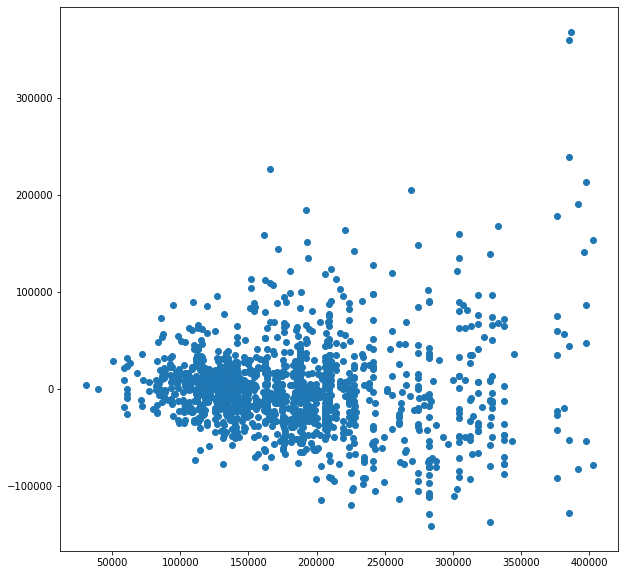

In [64]:
plt.figure(figsize=(10,10))
plt.scatter(predictions2, errors2)

This model does not meet the assumption ofhomoscedasticity.

In [65]:
X2.corr()

,const,102,103,104,105,106,107,108,109,3,...,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,FV,RH,RL,RM
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,NaN,1.000000,-0.007737,-0.011816,-0.066447,-0.026774,-0.023692,-0.013351,-0.007251,-0.006363,...,-0.013545,-0.012030,-0.014666,0.082636,-0.009583,-0.005108,-0.012654,-0.006171,-0.055734,0.041233
103,NaN,-0.007737,1.000000,-0.026604,-0.149612,-0.060285,-0.053346,-0.030062,-0.016326,-0.014326,...,-0.006429,-0.000275,-0.033022,-0.017422,-0.021577,-0.011500,-0.028491,0.036819,0.003762,-0.010857
104,NaN,-0.011816,-0.026604,1.000000,-0.228470,-0.092061,-0.081464,-0.045907,-0.024931,0.011086,...,0.034031,-0.005449,-0.050427,-0.026604,-0.010740,-0.017562,-0.043509,0.046715,-0.086019,0.084228
105,NaN,-0.066447,-0.149612,-0.228470,1.000000,-0.517712,-0.458117,-0.258162,-0.140202,-0.007202,...,-0.060501,0.103923,0.203125,0.084519,0.083519,-0.034896,0.177048,-0.053009,0.110727,-0.199842
106,NaN,-0.026774,-0.060285,-0.092061,-0.517712,1.000000,-0.184596,-0.104025,-0.056494,0.001111,...,0.018404,-0.056913,-0.091174,-0.046314,-0.006362,0.002125,-0.081015,0.038968,-0.002954,0.037493
107,NaN,-0.023692,-0.053346,-0.081464,-0.458117,-0.184596,1.000000,-0.092051,-0.049990,-0.007112,...,0.014467,-0.052904,-0.101114,-0.038149,-0.066069,0.033184,-0.087242,-0.023606,-0.031918,0.096200
108,NaN,-0.013351,-0.030062,-0.045907,-0.258162,-0.104025,-0.092051,1.000000,-0.028171,0.004766,...,0.062741,-0.030675,-0.056981,-0.030062,-0.037232,0.053319,-0.049163,0.036794,-0.075596,0.108721
109,NaN,-0.007251,-0.016326,-0.024931,-0.140202,-0.056494,-0.049990,-0.028171,1.000000,0.038984,...,-0.002949,-0.025383,-0.030945,-0.016326,-0.020220,-0.010777,-0.026699,-0.013020,-0.059789,0.090156
3,NaN,-0.006363,-0.014326,0.011086,-0.007202,0.001111,-0.007112,0.004766,0.038984,1.000000,...,0.004027,-0.022274,-0.027155,-0.014326,-0.017743,-0.009457,-0.023429,-0.011425,-0.162591,0.205330


Our variables appear to be only weakly correlated so we have met that assumption.

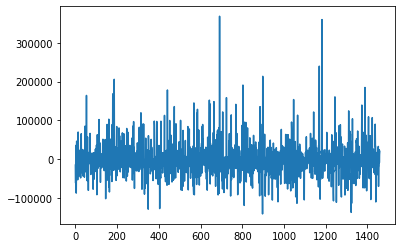

In [66]:
plt.plot(errors2)

/home/owenhw/conda/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


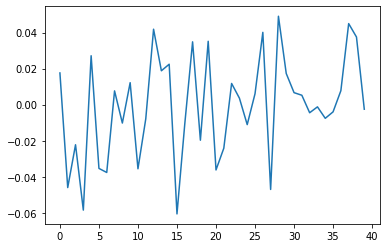

In [67]:
acf_data2 = acf(errors2)

plt.plot(acf_data2[1:])
plt.show()

Our errors are only weakly autocorrelated.

Jarque-Bera test statistics is 4888.976147251488 and p value is 0.0
Normality test statistics is 546.02339904006 and p value is 2.7072315548514436e-119


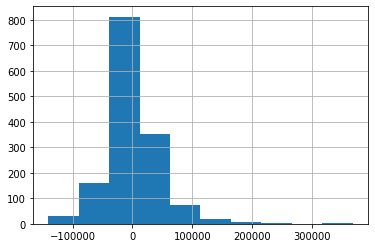

In [68]:
errors2.hist()

jb_stats = jarque_bera(errors2)
norm_stats = normaltest(errors2)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Our errors are not normally distributed.

Based on these results we likely have some missing key features as well as outliers to deal with.

Based on these results our first remedys should be to include more relevant featuers and do further transformation to normalize the featuers and target variable